In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
%matplotlib inline

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


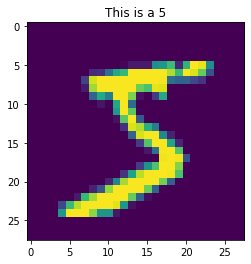

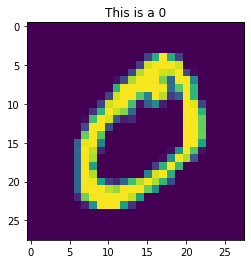

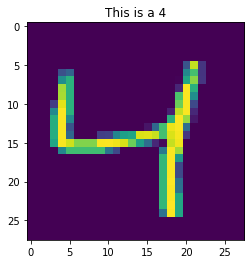

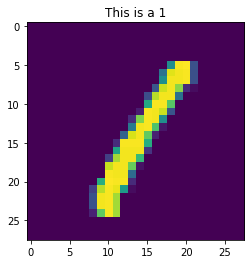

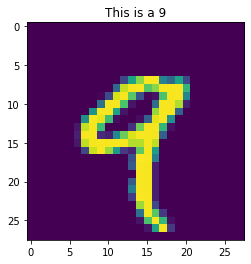

In [2]:
#The MNIST dataset is about 12 MB and will be downloaded automatically if it is not located in the given path.
mnist = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())
#Helper for visualization
def torch_imshow(img):
    img = img[0]
    plt.imshow(img.cpu().numpy())
    plt.show()

#Visualize first 5 samples
for n in range(5):
    sample = mnist[n]
    img, label = sample
    plt.figure()
    plt.title(f'This is a {label}')
    torch_imshow(img)


In [3]:
## Create a dataloader that bundles the dataset with batch size of 16
# You are free to shuffle data or not

train_dataloader = torch.utils.data.DataLoader(mnist, batch_size=16, shuffle=True)

In [4]:
## Add fully connected layers with “relu” activation to the network and make it 3-layer network with 
## 500, 500, 10 neurons, respectively. Train it for 1 epoch and try to obtain +95% test accuracy in one 
## epoch. You are free to choose any batch size, optimizer and learning rate.

def override_defalut_initialization(m):
  if isinstance(m, torch.nn.Linear):
      torch.nn.init.constant_(m.weight.data,0)
      torch.nn.init.constant_(m.bias.data, 0)
 

class ThreeLayerNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()


        self.layer1 = torch.nn.Linear(784,500)
        self.layer2 = torch.nn.Linear(500,500)
        self.layer3 = torch.nn.Linear(500,10)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x
        
three_layer_net = ThreeLayerNetwork().cuda()
three_layer_net.apply(override_defalut_initialization)

dummy_input = torch.randn(16, 784, device='cuda') #You can create tensors in GPU directly instead of .cuda()
dummy_output = three_layer_net(dummy_input)

print(f'Dummy input shape: {dummy_input.shape}')
print(f'Dummy output shape: {dummy_output.shape}')

Dummy input shape: torch.Size([16, 784])
Dummy output shape: torch.Size([16, 10])


In [5]:
# Define an SGD optimizer with learning rate 0.001 to optimize the parameters of "one_layer_net"
sgd_optimizer = torch.optim.SGD(three_layer_net.parameters(), lr=0.1)
print(sgd_optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [6]:
## Decide which loss function to use from torch.nn module and define it below
# Hint: The network does 'not' include a softmax activation at the output.

loss_fn = torch.nn.CrossEntropyLoss()

In [7]:
## Warning: If you run this cell multiple times, it will continue training
## after the first run so the plots may not be correct. Make sure you are not
## running this cell twice before restarting kernel.

loss_list = [] #To plot loss graph later

for train_images, train_labels in train_dataloader:
    ## Move data to GPU
    train_images, train_labels = train_images.cuda(), train_labels.cuda()
    
    ## Flatten the images from [BATCH, 1, 28, 28] to [BATCH, 784]
    flat_images = train_images.reshape(-1, 784)
    
    ## Run the network with flattened images batch and obtain the class scores
    class_scores = three_layer_net(flat_images)
    ## Calculate loss using the loss_fn defined above
    loss = loss_fn(class_scores, train_labels)
    loss_list.append(loss)
    
    ## Take an optimization step (don't forget to clear the gradients first)
    ################ FILL HERE ####################################
    # 1-Clear gradients
    # 2-Compute gradients using loss
    # 3-Take a gradient descent step using optimizer
    ###############################################################
    sgd_optimizer.zero_grad() #clear grads
    loss.backward() #compute grads
    sgd_optimizer.step() 
    
    
    

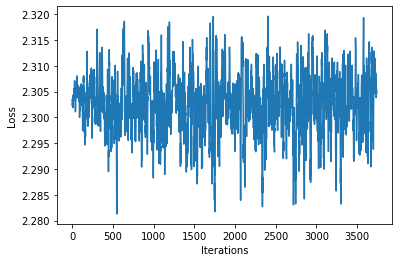

In [8]:
# Helper for plotting the loss graph smoothly. 
def plot_loss_graph(loss_list):
    filter_size = 10
    moving_average_filter = [1/filter_size] * filter_size
    smoothed_loss_list = np.convolve(loss_list, moving_average_filter, 'valid') 
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(smoothed_loss_list)
    plt.savefig('Question_5_lossGraph.png')
    
plot_loss_graph(loss_list)

In [9]:
## Test your network's accuracy on the test set

# Prepare test set
mnist_test = torchvision.datasets.MNIST('./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=False)


true_predictions = 0
false_predictions = 0
for test_images, test_labels in test_dataloader:
    ## Move batch to GPU
    test_images, test_labels = test_images.cuda(), test_labels.cuda()
    
    ## Flatten the images from [BATCH, 1, 28, 28] to [BATCH, 784]
    flat_images = test_images.reshape(-1, 784)
    
    ## Run the network with flattened images batch and obtain the class scores
    class_scores = three_layer_net(flat_images)
    
    ## Extract predictions from class_scores using torch.argmax() method
    class_predictions = torch.argmax(class_scores, dim=-1) #get argmax of the scores for each sample in the batch
    
    ## Find the number of true predictions in the batch using test_labels and class_predictions
    true_predictions_batch  = torch.sum(class_predictions == test_labels)
    false_predictions_batch = torch.sum(class_predictions != test_labels)
    
    true_predictions  += true_predictions_batch.item()
    false_predictions += false_predictions_batch.item()

accuracy = true_predictions / (true_predictions + false_predictions)
print(f'Accuracy = {accuracy*100}%')
     

Accuracy = 10.100000000000001%
